# w207 Spring 2019 - Final Project: Facial Keypoints Detection

by Michael Berger, Andre Fernandes, Vivian Lu, Sam Tosaria and Pauline Wang.

Date: March 24, 2019

## Introduction

The goal of our project is to build a well-performing machine learning algorithm to determine 15 facial keypoints from an image of a human face.  The data we use for training and testing is from the Kaggle [facial keypoint detection competition](https://www.kaggle.com/c/facial-keypoints-detection) which consists of 7000+ facial images of man, women and children.   

The problem we want to solve is essentially a regression problem. We have up to 30 variables, the x and y coordinates of the 15 facial keypoints, that need to be predicted using the 96x96 pixel values of an image.  However, the discrepency in the angle, orientation, and resolution of our training images makes this problem particularly challenging to solve using simply a regression algorithm.

Therefore, we will utilize a combination of **data augmentation and Convolutional Neural Networks (CNN)** to build a high performing machine learning model. As a baseline, we use a simple CNN with no hidden layer, trained on the raw images with complete labels. The metric we used for measuring error is the same as the Kaggle competition: the root mean squared error (RMSE) which is defined as:

$RMSE = \sqrt{ \frac{1}{n} \sum^n_{i=1} (y_i - \hat{y}_i)^2}$

The RMSE measures the average distance of each team's model predictions from the true coordinates of the 15 keypoints on the face.  For example, an RMSE of 3.00 means that, on average, the predictions are three pixel away from the true keypoint

### Workflow

Our analysis as summarized in this Jupyter Notebook is structured as follows:
 
- After this introduction and outline of the project, we load the libraries we use as well as the testing and training data.
- We then perform exploratory data analysis (EDA) on the training data to detect anomalies and identify potential of feature engineering. We also plot a couple of training images and associated keypoints as illustration.
- We train our baseline model and report the result. We discuss potential of improvements to be implemented.
- Next, we conduct feature engineering by transforming training images (e.g. mirroring) to create more data and explore the potential to use transfer learning from pre-trained neural networks as starting weights for our model.
- We finally implement our model.
- Last but not least, we discuss the results and summarize our findings.

## Exploration Data Analysis

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

`left_eye_center`, `right_eye_center`, `left_eye_inner_corner`, `left_eye_outer_corner`, `right_eye_inner_corner`, `right_eye_outer_corner`, `left_eyebrow_inner_end`, `left_eyebrow_outer_end`, `right_eyebrow_inner_end`, `right_eyebrow_outer_end`, `nose_tip`, `mouth_left_corner`, `mouth_right_corner`, `mouth_center_top_lip`, `mouth_center_bottom_lip`

Left and right here refers to the point of view of the subject.

In some examples the target keypoint positions are missing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0, 255). The images are 96x96 pixels.

We first import all the libaries required to build our model: 

In [24]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from sklearn.metrics import classification_report

from keras.models import Sequential 
from keras.layers import Dense, Dropout, Activation, Conv1D, Conv2D, Flatten, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras import optimizers

np.random.seed(0)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img

#PW: added warning ignore
import warnings
warnings.filterwarnings('ignore')
import time

In [2]:
# Here we extract the data files (NOTE: please enter data path)
path_train = 'C:/Users/wang_/Dropbox/PAULINE/Berkeley_MIDS/W207_Applied_ML/Project_Facial/training.csv'
path_test = 'C:/Users/wang_/Dropbox/PAULINE/Berkeley_MIDS/W207_Applied_ML/Project_Facial/test.csv'

df_train = pd.read_csv(path_train)
df_test = pd.read_csv(path_test)

In [3]:
# Taking a look at the first five rows of the training data
df_train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


We note from above that the pixel values are all squeezed into the last column and the labels are split in x- and y-coordinates (alternating) in the columns before. We next transform this data to get one dataset with only the pixel values, with each pixel being in one column.

In [4]:
# Processing training data such that each pixel has its own column and is seperated from the labels
kaggle_train = df_train.loc[:,'Image'].T
kaggle_train = kaggle_train.astype(str)
kaggle_train = kaggle_train.str.split(" ", expand = True) 
kaggle_train.head()

,0,1,2,3,4,5,6,7,8,9,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,238,236,237,238,240,240,239,241,241,243,...,33,29,30,34,39,49,62,70,75,90
1,219,215,204,196,204,211,212,200,180,168,...,1,1,1,1,1,1,1,1,1,1
2,144,142,159,180,188,188,184,180,167,132,...,64,60,56,61,70,69,71,78,78,77
3,193,192,193,194,194,194,193,192,168,111,...,1,1,1,1,1,1,1,1,1,1
4,147,148,160,196,215,214,216,217,219,220,...,33,34,37,37,43,46,83,140,170,176


In [5]:
# Creates labels for facial feature position
labels = df_train.iloc[:, 0:30] 
labels.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

We also preprocess the test data (similarly, the pixel values are squeezed in the last column and the first column represents the test ID.

In [6]:
# processing test data such that each pixel has its own column,
# merging it then with the ImageId column
image_test = df_test.loc[:,'Image'].T
image_test = image_test.astype(str)
image_test = image_test.str.split(" ", expand = True)
kaggle_test = pd.DataFrame(df_test.loc[:,'ImageId']).join(image_test)
kaggle_test.head()

,ImageId,0,1,2,3,4,5,6,7,8,...,9206,9207,9208,9209,9210,9211,9212,9213,9214,9215
0,1,182,183,182,182,180,180,176,169,156,...,6,14,28,28,24,18,12,8,5,5
1,2,76,87,81,72,65,59,64,76,69,...,156,152,162,169,168,159,191,228,211,168
2,3,177,176,174,170,169,169,168,166,166,...,1,1,1,1,1,1,1,1,1,1
3,4,176,174,174,175,174,174,176,176,175,...,144,143,141,142,143,142,142,142,142,140
4,5,50,47,44,101,144,149,120,58,48,...,254,254,254,253,255,236,174,175,175,165


Next, we check any missing values in test or train and check the shapes of the pandas dataframe. A call of the summary statistics of the train data does not seem to add value as the data is image data.

In [7]:
# Missing values kaggle_training?
print("Missing values pixel data:", kaggle_train.columns[kaggle_train.isna().any()].tolist())

# Missing values in labels?
print("Missing values labels:", labels.columns[labels.isna().any()].tolist())

# Shapes
print("Train data shape:", kaggle_train.shape)
print("Test data shape:", kaggle_test.shape)

Missing values pixel data: []
Missing values labels: ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
Train data shape: (7049, 9216)
Test data shape: (1783, 9217)


We see that we have no missing values in the training pixel data, but in the labels. The shapes of train and test look as expected. The summary statistics  We next look at which labels have missing values.

In [8]:
# How many observations have missing values per label coordinate?
labels.isnull().sum()

left_eye_center_x              10
left_eye_center_y              10
right_eye_center_x             13
right_eye_center_y             13
left_eye_inner_corner_x      4778
left_eye_inner_corner_y      4778
left_eye_outer_corner_x      4782
left_eye_outer_corner_y      4782
right_eye_inner_corner_x     4781
right_eye_inner_corner_y     4781
right_eye_outer_corner_x     4781
right_eye_outer_corner_y     4781
left_eyebrow_inner_end_x     4779
left_eyebrow_inner_end_y     4779
left_eyebrow_outer_end_x     4824
left_eyebrow_outer_end_y     4824
right_eyebrow_inner_end_x    4779
right_eyebrow_inner_end_y    4779
right_eyebrow_outer_end_x    4813
right_eyebrow_outer_end_y    4813
nose_tip_x                      0
nose_tip_y                      0
mouth_left_corner_x          4780
mouth_left_corner_y          4780
mouth_right_corner_x         4779
mouth_right_corner_y         4779
mouth_center_top_lip_x       4774
mouth_center_top_lip_y       4774
mouth_center_bottom_lip_x      33
mouth_center_b

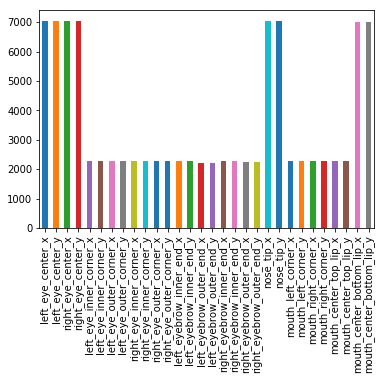

In [9]:
# The same information displayed visually
labels.describe().loc['count'].plot.bar()

In [10]:
# Percentage missing per label
labels.isnull().sum() / labels.shape[0]

left_eye_center_x            0.001419
left_eye_center_y            0.001419
right_eye_center_x           0.001844
right_eye_center_y           0.001844
left_eye_inner_corner_x      0.677827
left_eye_inner_corner_y      0.677827
left_eye_outer_corner_x      0.678394
left_eye_outer_corner_y      0.678394
right_eye_inner_corner_x     0.678252
right_eye_inner_corner_y     0.678252
right_eye_outer_corner_x     0.678252
right_eye_outer_corner_y     0.678252
left_eyebrow_inner_end_x     0.677969
left_eyebrow_inner_end_y     0.677969
left_eyebrow_outer_end_x     0.684352
left_eyebrow_outer_end_y     0.684352
right_eyebrow_inner_end_x    0.677969
right_eyebrow_inner_end_y    0.677969
right_eyebrow_outer_end_x    0.682792
right_eyebrow_outer_end_y    0.682792
nose_tip_x                   0.000000
nose_tip_y                   0.000000
mouth_left_corner_x          0.678110
mouth_left_corner_y          0.678110
mouth_right_corner_x         0.677969
mouth_right_corner_y         0.677969
mouth_center

We have missing values in the labels, but none in the pixel data. The percentage of missing values can be as high as 68%, especially on labels for the eye corners, the eyebrows and the mouth corners and top lip.

This means we have an imbalance in the number of examples per value that we want to regress on. We can think about increasing the number of training data by image transformations, like mirroring, or try to augment the missing labels. For the baseline model, however, we decided to only take the observations with no missing label information.

We next proceed to plot 20 images with the corresponding facial keypoints.

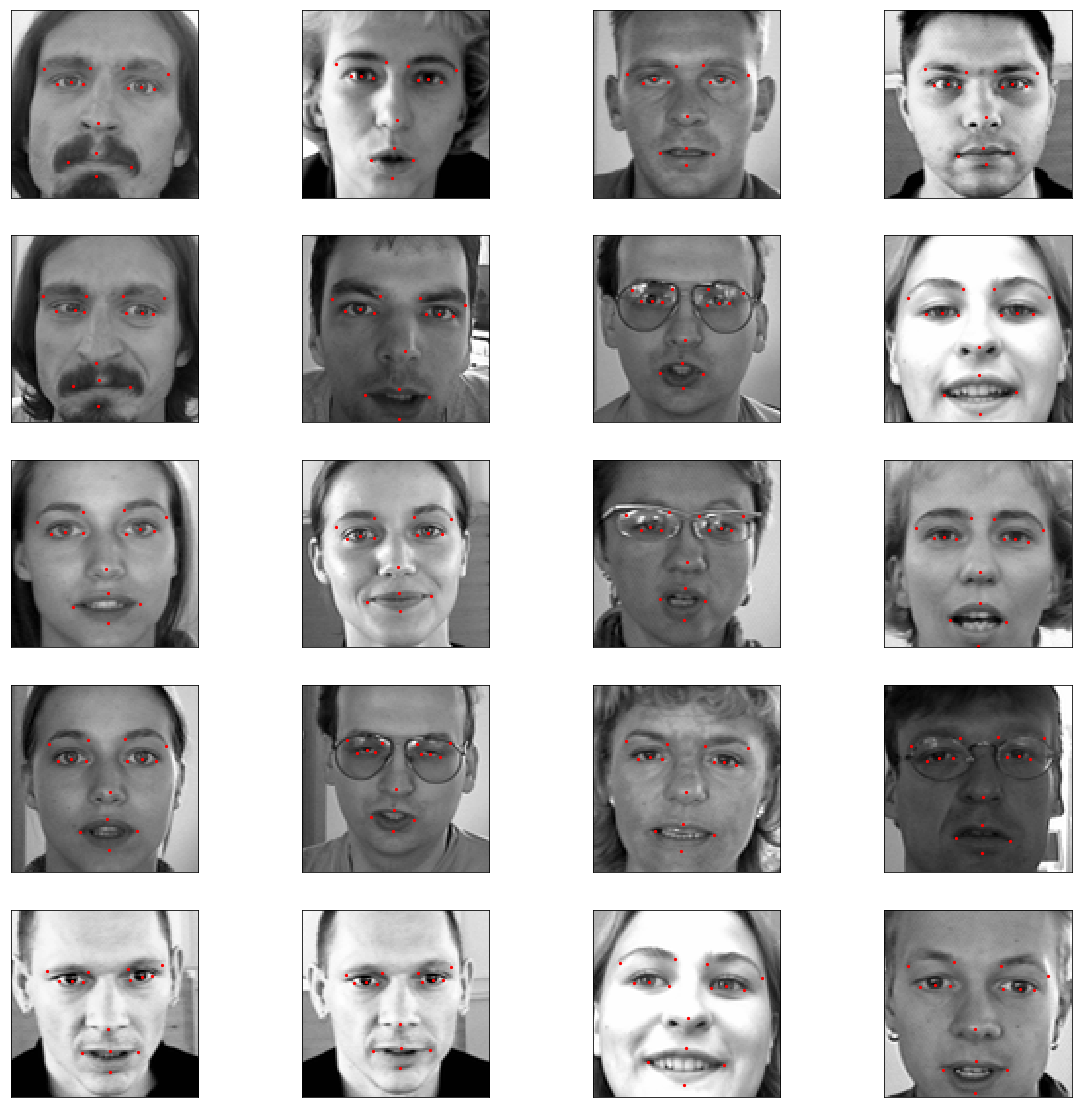

In [11]:
# Plotting some of the image data with keypoints
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(20):
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1

plt.show()

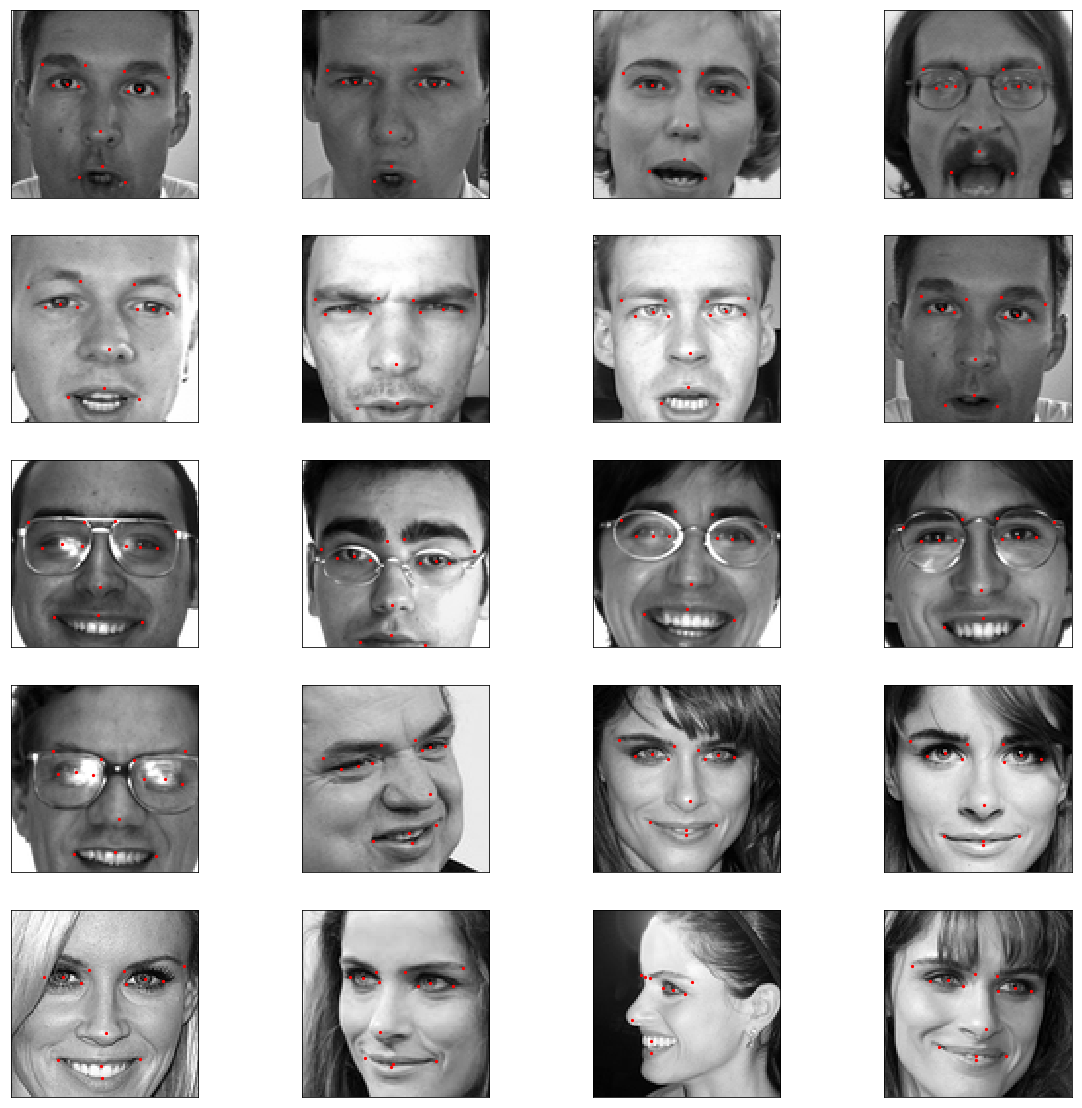

In [12]:
# Plotting some images with missing keypoints 
position = 1

fig = plt.figure(figsize = (20, 20))

for index in range(labels.shape[0]):
    
    if sum(labels.iloc[index,:].isnull()) == 0:
        continue
        
    sub = fig.add_subplot(5, 4, position)
    plt.imshow(np.reshape(np.array(kaggle_train.iloc[index,:].astype(int)), (96, 96)), cmap = 'gray')
    
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(labels.iloc[index,coord], labels.iloc[index,coord+1], c = 'red', s = 5)

    sub.set_xticks([])
    sub.set_yticks([])
    
    position += 1
    
    if position > 20:
        break

plt.show()

## Baseline Model##

In this section, we illustrate classifying facial key points using a simple neural network model with no hidden layer as our baseline model. The purpose of the baseline model is to compare and contrast the improvement of classifer with our data augumentation and feature engineering in the subsequent sections.  We will also use the baseline model to evaluate the value of the hidden layers .  

### Data Transfomation
We first drop all the images that contains one or more missing facial keypoint values.  From the EDA section, we identify only 2140 images out of the total 7049 with all 30 facial keypoint intact.  We refer to these images as "High Quality" and will run our baseline CNN model based on this subset of images.  We ran through a list of codes below to transform the data into our desired shape and format. 

In [13]:
# We drop all images with mising value which left us with 2140 images. We examine the shape of the data to make sure that it is correct. 
hq_image = df_train.dropna() 
print(hq_image.shape)

(2140, 31)


In [14]:
def string_image(string):
    """This functions converts a string to a numpy array. This is used to transform the 'Image' column"""
    return np.array([int(item) for item in string.split()]).reshape((96, 96))

In [145]:
#convert the "image" column to 96x96 images for plotting the data later
X = np.stack([string_image(string) for string in hq_image['Image']]).astype(np.float)[:, :, :, np.newaxis]
#convert the rest of the data to 2140 lists with 30 key facial keypoint positions
y = np.vstack(hq_image[hq_image.columns[:-1]].values)
#print(X.shape, X.dtype)
#print(y.shape, y.dtype)


[65.37807194 35.63202302 30.19096403 34.39742158 59.51309353 36.5579741
 71.85979856 35.94067338 35.12978417 35.94067338 24.32667626 34.70607194
 58.89634532 29.15022734 77.10664748 26.37230504 38.83372662 29.4588777
 17.84494964 27.29832518 45.93220144 64.02854676 60.13053237 76.992
 32.04328058 76.68328058 45.00673381 73.59677698 45.31545324 84.39988489]


In [146]:
print(y[34])
print(y.shape)

[65.37807194 35.63202302 30.19096403 34.39742158 59.51309353 36.5579741
 71.85979856 35.94067338 35.12978417 35.94067338 24.32667626 34.70607194
 58.89634532 29.15022734 77.10664748 26.37230504 38.83372662 29.4588777
 17.84494964 27.29832518 45.93220144 64.02854676 60.13053237 76.992
 32.04328058 76.68328058 45.00673381 73.59677698 45.31545324 84.39988489]
(2140, 30)


In [22]:
X_train = X / 255.#normalize image pixel to between 0 and 1

### Model Building

We instantiate a sequential model with no hidden layer as our baseline model with most of the default hyperparameters.  We select the activation function, softmax, as it calculates the probabilities of each target class over all possible target classes. The output dimension is 30 as there are 15 pairs of x, y coordinates and the imput dimension is 9216 to represent the 96 x 96 pixels. We then run the optimizer, setting the learning rate to be 0.01 and using 200 epochs, to calculate the accuracy and loss of our baseline model.  

In [47]:
base_model = Sequential()#isntantiate a base sequential model
base_model.add(Dense(30, input_dim=9216, activation="relu")) #set the output, input and activation function. 
base_model.add(Dense(30)) #the output has no activation function so it's a regression problem 

In [48]:
start_time=time.time()
sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
base_model.compile(optimizer=sgd, loss='mean_squared_error', metrics=['accuracy'])
epochs = 100
history = base_model.fit(X_train.reshape(y.shape[0], -1), y, validation_split=0.2, shuffle=True, epochs=epochs, batch_size=20)

total_time=time.time()-start_time
print("The model took {} seconds to run".format(round(total_time,3)))

Train on 1712 samples, validate on 428 samples
Epoch 1/100
1712/1712 [==============================] - 1s 427us/step - loss: 10762.9467 - acc: 0.5350 - val_loss: 972.5092 - val_acc: 0.4322
Epoch 2/100
1712/1712 [==============================] - 1s 304us/step - loss: 545.4495 - acc: 0.7734 - val_loss: 307.3188 - val_acc: 0.4322
Epoch 3/100
1712/1712 [==============================] - 1s 301us/step - loss: 166.8052 - acc: 0.7734 - val_loss: 107.4662 - val_acc: 0.4322
Epoch 4/100
1712/1712 [==============================] - 1s 302us/step - loss: 55.1847 - acc: 0.7734 - val_loss: 46.3330 - val_acc: 0.4322
Epoch 5/100
1712/1712 [==============================] - 1s 294us/step - loss: 22.2624 - acc: 0.7734 - val_loss: 27.2361 - val_acc: 0.4322
Epoch 6/100
1712/1712 [==============================] - 1s 302us/step - loss: 12.5544 - acc: 0.7734 - val_loss: 20.9491 - val_acc: 0.4322
Epoch 7/100
1712/1712 [==============================] - 0s 290us/step - loss: 9.6811 - acc: 0.7734 - val_loss:

We plot out our baseline model accuracy and loss with 100 epochs. As indicated by the plots below, the accuracy increases drastically for epoch 0-25 and plateaued at around xx and xx for the train and test set.  Similiar pattern is observed for the loss, which reduced sharply for epoch 0-25 and flattened to be around xx and xx for the train and test sets. **The result suggests that there is much room for improvement for our baseline model**. 

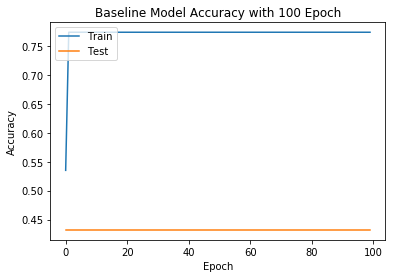

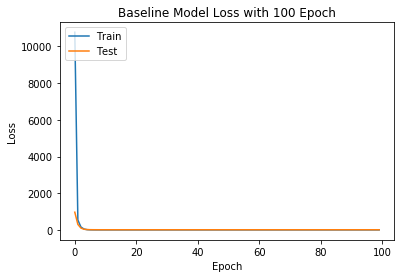

In [49]:
#We plot the history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Baseline Model Accuracy with {} Epoch'.format (epochs))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# We plot summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Baseline Model Loss with {} Epoch'.format(epochs))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Next, we put our predicted labels on the facial images to see how they perform.  As expected, the facial images with any kind of distortation (e.g. face tilted to an angle) or obfuscation (e.g. hats, sunglasses, bangs) are particually inaccurate in how the keypoints are labeled.   

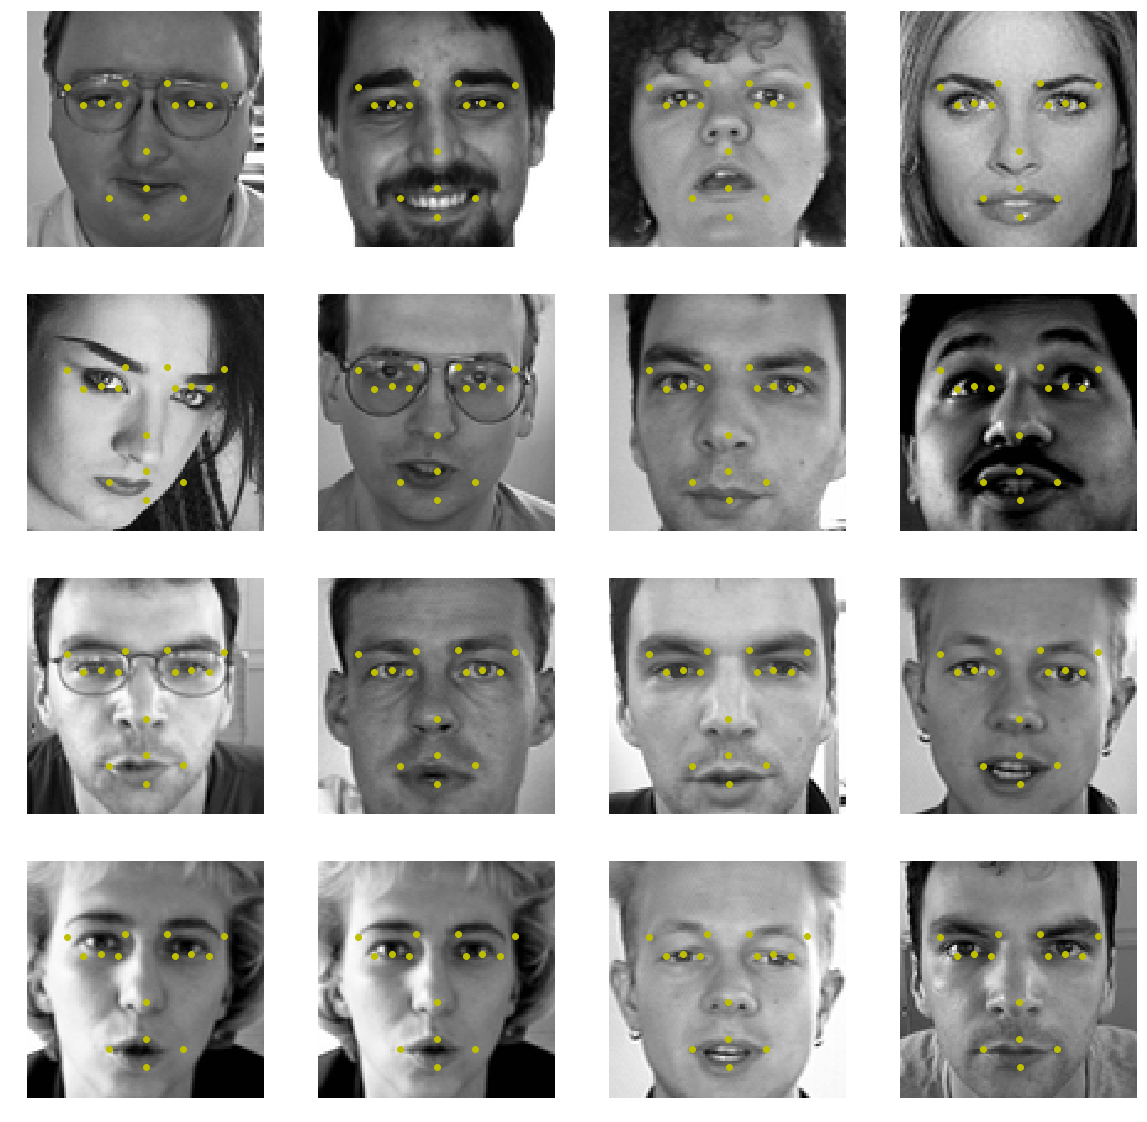

In [122]:
#we plot the prediction with facial images

def plot_faces_with_keypoints_and_predictions(model, nrows=4, ncols=4, model_input='flat'):
    """Plots sampled faces with their predicted labels."""
    selection = np.random.choice(np.arange(X.shape[0]), size=(nrows*ncols), replace=False) #prints a list of random number 
    fig, axes = plt.subplots(figsize=(20, 20), nrows=nrows, ncols=ncols)
    for ind, ax in zip(selection, axes.ravel()):
        img = X_train[ind, :, :, 0]
        if model_input == 'flat':
            predictions = model.predict(img.reshape(1, -1))
        else:
            predictions = model.predict(img[np.newaxis, :, :, np.newaxis])
        xy_predictions=predictions.reshape(15,2)
        ax.imshow(img, cmap='gray')
        ax.plot(xy_predictions[:, 0], xy_predictions[:, 1], 'yo')
        ax.axis('off')
      
plot_faces_with_keypoints_and_predictions(base_model)

In [170]:
def predictions_vs_labels(index):
    '''This function plots the predicted label from our baseline model vs the actual label'''
    index=index
    plt.imshow(X_train[index, :, :, 0], cmap = 'gray')
    
    for i in range(0,2140): # we save all the prediction to a list
        img=X_train[i,:,:,0]
        predictions = base_model.predict(img.reshape(1, -1))
        predict_list.append(predictions)
        
    for coord in range(0, labels.iloc[index,:].shape[0]-1, 2):
        if coord == None:
            continue
        else:
            plt.gca().scatter(y[index][coord], y[index][coord+1], c = 'red', s = 7) #plot the actual label
            plt.gca().scatter(predict_list[index][0][coord],predict_list[index][0][coord+1], c='yellow', s=7 )#plot the prediction
    plt.show()

### Sectional Summary ###

From the accuracy and loss plots above, it's apparent that our model overfits and therefore the performance is weak on the validation set, regardless the number of epoches.  There are a few reasons that our baseline model does not not perform well:

- **Insufficient training data**: Our EDA shows that only about 2000 images have all labels intact.  By excluding images with missing labels, we reduced our training data set to 30%.  


- **Suboptimized model learning rate**: The accuracy and loss plots show that the accuracy and loss plateued after several epoches. This suggests that we need to modify our CNN by introducing hidden layers or changing the hyparameters. 


- **Image augmentation is required**: As shown in the images below, our model is weak in predicting facial images that are distorted, tilted or obfuscated. We will need to reprocess these images by introducing additional features or by image reprocessing. 

Example of an image with obfuscations.
The prediction mistaken the frame of the glasses as eyebrow 


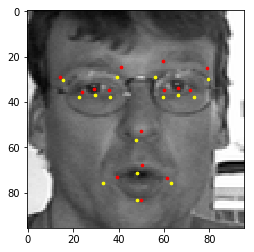

Examples of a tilted image.
The predicited labels assume that key points are symmetry which perfrom poorly when the facial images are at an angle.


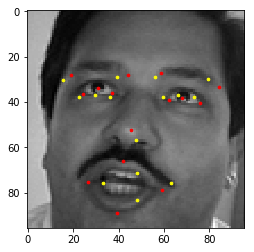

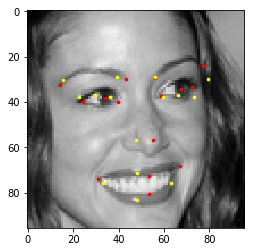

In [226]:
print ("Example of an image with obfuscations.") 
print ("The prediction mistaken the frame of the glasses as eyebrow ")
predictions_vs_labels(24)
       
print ("Examples of a tilted image.")
print ("The predicited labels assume that key points are symmetry which perfrom poorly when the facial images are at an angle.")
predictions_vs_labels(980)
predictions_vs_labels(1775)

In the next sections, we will explore methods to improve our model through feature engineering and by augmenting the image data to increase our training set. 